In [192]:
import pydicom
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
BASEDIR = "D:\\H_N"

In [3]:
subdirs = [os.path.join(BASEDIR,folder) for folder in os.listdir(BASEDIR) if os.path.isdir(os.path.join(BASEDIR,folder))]

In [4]:
haveall = []
notall = []
for patient in subdirs:
    files = os.listdir(patient)
    headers = [file[:2] for file in files]
    unique = list(set(headers))
    if not all(('CT' in unique,'RS' in unique,'RD' in unique)):
        print("Missing element for patient {}".format(patient.split("\\")[-1]))
        print(unique)
        notall.append(patient)
    else:
        haveall.append(patient)
print("Num good patients: {}".format(len(haveall)))

Missing element for patient .ipynb_checkpoints
['su']
Missing element for patient 017_056_w_PET
['CT', 'PE', 'RS']
Missing element for patient 017_068
['CT', 'RS']
Missing element for patient 017_074
['CT', 'RS']
Missing element for patient 017_106
['RD', 'RP', 'RS']
Missing element for patient 017_134
['CT', 'PE', 'RS']
Missing element for patient 017_135
['CT', 'PE', 'RS']
Missing element for patient 018_049
['CT', 'RS']
Num good patients: 224


In [5]:
testpatient1 = haveall[5]
testpatient2 = haveall[120]

In [6]:
testfiles1 = [file for file in os.listdir(testpatient1) if any((file.startswith('CT'),file.startswith('RS'),file.startswith('RD')))]
testfiles2 = [file for file in os.listdir(testpatient2) if any((file.startswith('CT'),file.startswith('RS'),file.startswith('RD')))]

In [43]:
dose = None
image = None
ss = None
for file in testfiles1:
    if file.startswith('RD'):
        print(file)
        dose = pydicom.read_file(os.path.join(testpatient1,file))
    if file.startswith('CT'):
        image = pydicom.read_file(os.path.join(testpatient1,file))
    if file.startswith('RS'):
        print(file)
        ss = pydicom.read_file(os.path.join(testpatient1,file))
    if not any((dose is None, image is None, ss is None)):
        break

RD.017_056.0_70.dcm
RS.017_056.CT_9.18.15.dcm


In [8]:
dosearray = dose.pixel_array

In [9]:
print(dose.Rows,dose.Columns,dose.PixelSpacing)

141 283 [2, 2]


In [10]:
len(testfiles1)

196

### Need to develop a function that loads dose, CT, and structure set. We care about the BODY contour - the dose data should all fall within the BODY!

In [17]:
z_pos = np.array(dose.GridFrameOffsetVector) + dose.ImagePositionPatient[-1]

In [152]:
def getscaledimg(file):
    image = file.pixel_array.astype(np.int16)
    slope = file.RescaleSlope
    intercept = file.RescaleIntercept
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return image

def get_slices(image, dose, mask=None):
    dosearray = dose.pixel_array * float(dose.DoseGridScaling)
    imagearray = getscaledimg(image)
    
    image_pos = image.ImagePositionPatient[-1]
    z_list = np.array(dose.GridFrameOffsetVector) + dose.ImagePositionPatient[-1]
    dose_slice_idx = np.squeeze(np.argwhere(z_list == image_pos))
    dose_slice = dosearray[dose_slice_idx,:,:]
    
    Xcorner = image.ImagePositionPatient[0]
    Ycorner = image.ImagePositionPatient[1]
    
    imgXcoords = np.arange(Xcorner, Xcorner + (image.Rows*image.PixelSpacing[0]),image.PixelSpacing[0])
    imgYcoords = np.arange(Ycorner, Ycorner + (image.Columns*image.PixelSpacing[1]),image.PixelSpacing[1])
    doseminX = dose.ImagePositionPatient[0]
    doseminY = dose.ImagePositionPatient[1]
    dosemaxX = dose.ImagePositionPatient[0] + dose.PixelSpacing[0]*dose.pixel_array.shape[2]
    dosemaxY = dose.ImagePositionPatient[1] + dose.PixelSpacing[1]*dose.pixel_array.shape[1]
    imgXkeep = np.squeeze(np.argwhere((doseminX < imgXcoords)&(imgXcoords < dosemaxX)))
    imgYkeep = np.squeeze(np.argwhere((doseminY < imgYcoords)&(imgYcoords < dosemaxY)))
    
    trimmedimage = imagearray[imgYkeep,:]
    trimmedimage = trimmedimage[:,imgXkeep]

    #newimage = cv2.resize(trimmedimage,(dose_slice.shape[1],dose_slice.shape[0]),interpolation=cv2.INTER_AREA)
    newdose = cv2.resize(dose_slice, (trimmedimage.shape[1],trimmedimage.shape[0]),interpolation=cv2.INTER_AREA)
    
    if mask is None:
        return trimmedimage, newdose
    else:
        trimmedmask = mask[imgYkeep,:]
        trimmedmask = trimmedmask[:,imgXkeep]
        return trimmedimage, newdose, trimmedmask

In [23]:
imagefiles = [file for file in testfiles1 if file.startswith("CT")]
print(len(imagefiles))

193


In [277]:
select = 20

image = pydicom.read_file(os.path.join(testpatient1,imagefiles[select]))

img,dose_slice = get_slices(image,dose)

In theory, dose should always be smaller than images. We should be able to set real-space values to each image pixel position, then trim the image to the real-space dimensions of the dose array. From this we can resize the dose array to match the image resolution using opencv.

Note that this is dependent on both the image and the dose array having "normal" ImageOrientationPatient.

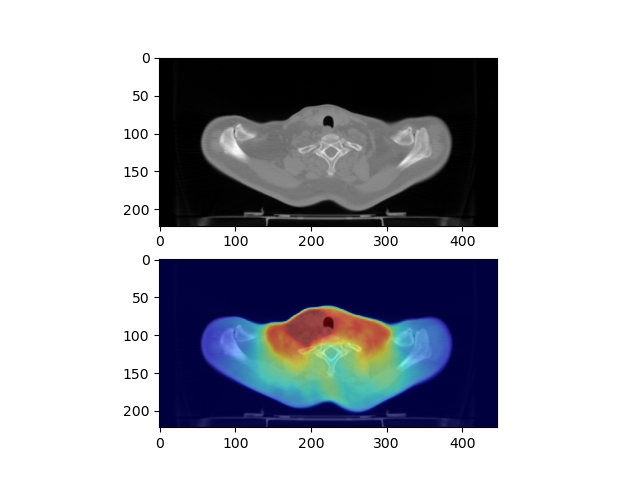

In [278]:
%matplotlib widget

fig,axes = plt.subplots(2,1)
axes[0].imshow(img,cmap='gray')
axes[1].imshow(img,cmap='gray')
axes[1].imshow(dose_slice,cmap='jet',alpha=0.5)

Works perfectly! Now we just need to quantify what "aligned" means - probably want to try converting the image array to a boolean array

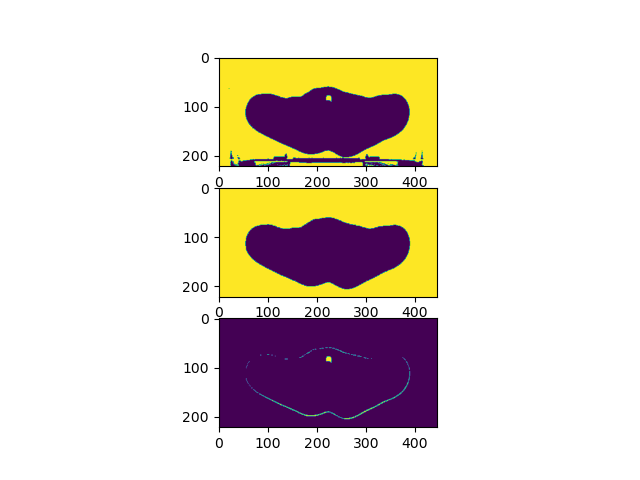

In [279]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(img < -900)
ax[1].imshow(dose_slice < 0.5)
result = (img < -900) ^ (dose_slice < 0.5)
result[dose_slice < 0.5] = False
ax[2].imshow(result)

In [280]:
def list_contours(ss):
    # lists all ROI Names 
    all_contours = {}
    for each in ss.StructureSetROISequence:
        all_contours[each.ROIName] = each.ROINumber
    return all_contours

def get_contour(ss,ROI):
    # retrieves ContourSequence for the requested ROI, default is BODY. accepts either name or number
    try:
        ROI_num = int(ROI)
    except ValueError:
        for info in ss.StructureSetROISequence:
            if info.ROIName == ROI:
                ROI_num = info.ROINumber
                
    for contourseq in ss.ROIContourSequence:
        if contourseq.ReferencedROINumber == ROI_num:
            return contourseq.ContourSequence
        
def pull_single_slice(seq, image):
    # gets contour coords for slice corresponding to image (by z position)
    z = image.ImagePositionPatient[-1]
    for plane in seq:
        if plane.ContourData[2] == z:
            coords = np.reshape(plane.ContourData, (int(len(plane.ContourData)/3),3))
            coords = np.array([coords[:,0],coords[:,1]])
            coords = np.transpose(coords)
            return coords
    print("No slice match found")
    return None

def coords_to_mask(coords, image):
    Xcorner = image.ImagePositionPatient[0]
    Ycorner = image.ImagePositionPatient[1]
    imgXcoords = np.arange(Xcorner, Xcorner + (image.Rows*image.PixelSpacing[0]),image.PixelSpacing[0])
    imgYcoords = np.arange(Ycorner, Ycorner + (image.Columns*image.PixelSpacing[1]),image.PixelSpacing[1])
    
    mask = np.zeros_like(image.pixel_array)
    for point in coords:
        X_pos = np.argmin(np.abs(imgXcoords - point[0]))
        Y_pos = np.argmin(np.abs(imgYcoords - point[1]))
        mask[Y_pos,X_pos] = 1
        
    points = np.array(np.where(mask))
    points = np.array([points[1,:], points[0,:]]).T
    filledmask = cv2.fillPoly(mask,pts=[sort_coords(points)],color=1)
    # note - only works with congruous single volume ROIs. should be fine for now.
    return filledmask

def sort_coords(coords):

    origin = coords.mean(axis=0)
    refvec = [0,1]

    def clockwiseangle_and_dist(point):
        nonlocal origin
        nonlocal refvec
        # Vector between point and the origin: v = p - o
        vector = [point[0]-origin[0], point[1]-origin[1]]
        # Length of vector: ||v||
        lenvector = math.hypot(vector[0], vector[1])
        # If length is zero there is no angle
        if lenvector == 0:
            return -math.pi, 0
        # Normalize vector: v/||v||
        normalized = [vector[0]/lenvector, vector[1]/lenvector]
        dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
        diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
        angle = math.atan2(diffprod, dotprod)
        # Negative angles represent counter-clockwise angles so we need to subtract them 
        # from 2*pi (360 degrees)
        if angle < 0:
            return 2*math.pi+angle, lenvector
        # I return first the angle because that's the primary sorting criterium
        # but if two vectors have the same angle then the shorter distance should come first.
        return angle, lenvector
    sorted_coords = sorted(coords, key=clockwiseangle_and_dist)
    return np.array(sorted_coords)

In [281]:
contours = get_contour(ss,1)

In [282]:
coords = pull_single_slice(contours,image)
mask = coords_to_mask(coords,image)
# points = np.array(np.where(mask))
# points = np.array([points[1,:], points[0,:]]).T
# filledmask = cv2.fillPoly(mask,pts=[sort_coords(points)],color=1)
testim, testdose, testmask = get_slices(image,dose,mask)

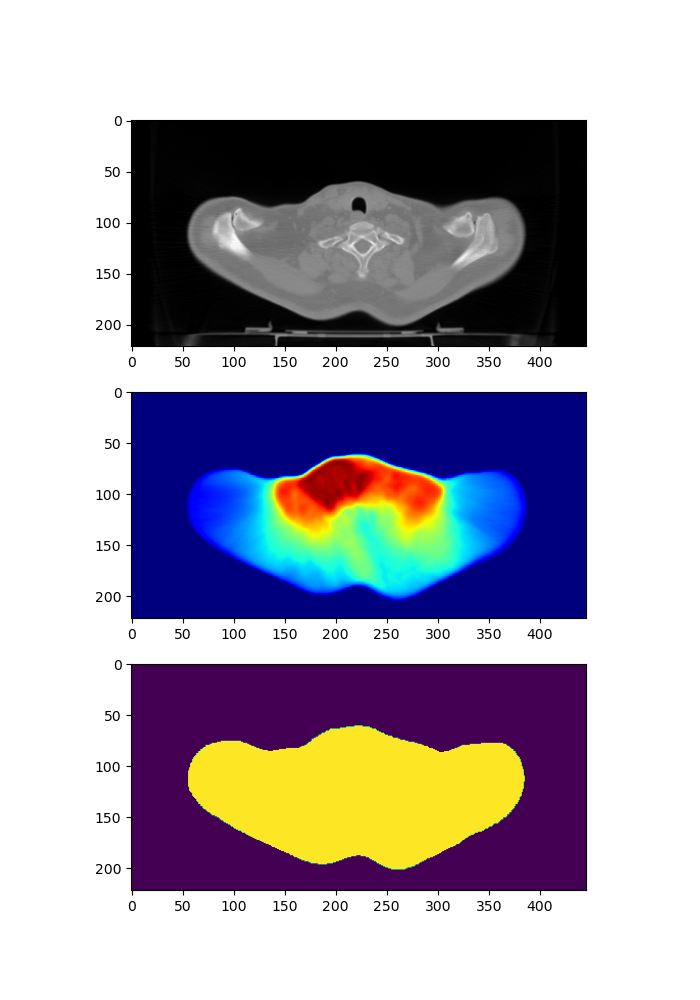

In [283]:
fig, ax = plt.subplots(3,1,figsize=(7,10))
ax[0].imshow(testim,cmap='gray')
ax[1].imshow(testdose,cmap='jet')
ax[2].imshow(testmask)

In [262]:
def score_slices(img,dose,bodymask,witharrays=False):
    binary_dose = dose > 0.5
    binary_im = img > -900
    binary_mask = (bodymask == 1)
    # calculate dose not in body contour
    airdose = binary_dose ^ binary_mask
    airdose[~binary_dose] = False
    airdose_px = np.sum(airdose) # number of pixels of meaningful dose not contained in body contour - we expect zero
    # now check contour against air
    bodyair = binary_mask ^ binary_im
    bodyair[~binary_mask] = False
    percent_bodyair = round(100*np.sum(bodyair)/np.sum(binary_mask),3)
    if witharrays == False:
        return airdose_px, percent_bodyair
    else:
        return airdose_px, percent_bodyair, (airdose,bodyair)

In [263]:
def full_eval(image,dose,ss,witharrays=False):
    contours = get_contour(ss,'BODY')
    coords = pull_single_slice(contours,image)
    if coords is None:
        print("No contour data for this image, check image file compatibility.")
    mask = coords_to_mask(coords, image)
    testim, testdose,testmask = get_slices(image,dose,mask)
    return score_slices(testim,testdose,testmask,witharrays)
        

In [267]:
for i,filepath in enumerate(imagefiles):

    image = pydicom.read_file(os.path.join(testpatient1,filepath))
    coords = pull_single_slice(contours,image)
    if coords is None:
        print(filepath, "no good, continuing")
        continue
    mask = coords_to_mask(coords,image)
    testim, testdose, testmask = get_slices(image,dose,mask)
    airdose_px, perc_bodyair = score_slices(testim,testdose,testmask)
    if airdose_px > 2500 or perc_bodyair > 1.0:
        print("{i}: For {fp}, air dose pixels {a}, body air percent {b}%".format(i=i,fp=filepath,a=airdose_px,b=perc_bodyair))

No slice match found
CT.017_056.Image 1.dcm no good, continuing
No slice match found
CT.017_056.Image 2.dcm no good, continuing
No slice match found
CT.017_056.Image 3.dcm no good, continuing
No slice match found
CT.017_056.Image 4.dcm no good, continuing
131: For CT.017_056.Image 43.dcm, air dose pixels 830, body air percent 1.091%
132: For CT.017_056.Image 44.dcm, air dose pixels 834, body air percent 1.472%
133: For CT.017_056.Image 45.dcm, air dose pixels 851, body air percent 1.765%
134: For CT.017_056.Image 46.dcm, air dose pixels 929, body air percent 1.866%
135: For CT.017_056.Image 47.dcm, air dose pixels 1056, body air percent 2.383%
136: For CT.017_056.Image 48.dcm, air dose pixels 970, body air percent 4.326%
137: For CT.017_056.Image 49.dcm, air dose pixels 940, body air percent 6.009%
139: For CT.017_056.Image 50.dcm, air dose pixels 927, body air percent 6.975%
140: For CT.017_056.Image 51.dcm, air dose pixels 1134, body air percent 7.279%
141: For CT.017_056.Image 52.dc

In [271]:
select = 50
image = pydicom.read_file(os.path.join(testpatient1,imagefiles[select]))
ad,pba, arrays = full_eval(image,dose,ss,witharrays=True)

Text(0.5, 1.0, 'Air in Body Contour')

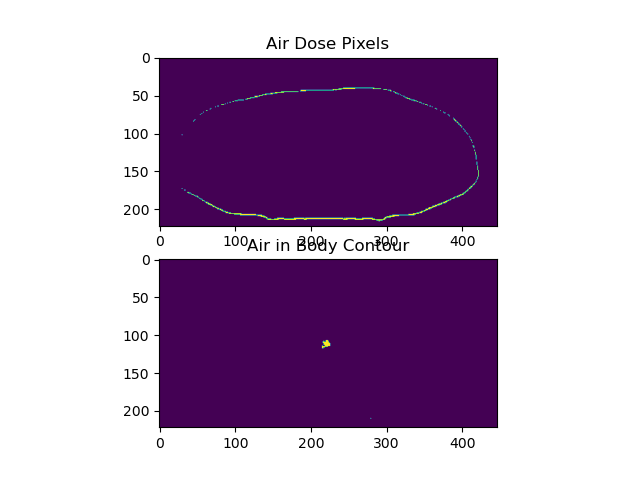

In [272]:
fig,axes = plt.subplots(2,1)
axes[0].imshow(arrays[0])
axes[0].set_title("Air Dose Pixels")
axes[1].imshow(arrays[1])
axes[1].set_title("Air in Body Contour")

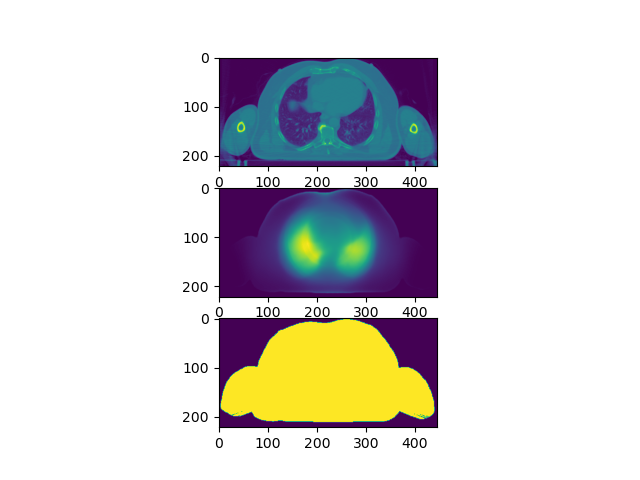

In [261]:
coords = pull_single_slice(contours,image)

mask = coords_to_mask(coords,image)
testim, testdose, testmask = get_slices(image,dose,mask)

fig,ax = plt.subplots(3,1)
ax[0].imshow(testim)
ax[1].imshow(testdose)
ax[2].imshow(testmask)